# Minimal Cut Sets (MCS)

The minimal cut set approach aims to find a minimum set of network intervetions that enforce some pre-definde behavior in a metabolic network. It may be used to suppress growth, suppress or enforce the synthesis of a certain product or to couple or decouple metabolic fluxes.

For the shown examples, we again load the COBRApy and the StrainDesign packages. As well as the small E. coli textbook-network "e_coli_core" and the example network "SmallExample".

In [1]:
import straindesign as sd
import cobra

ecc = cobra.io.load_model('e_coli_core')
model = cobra.io.read_sbml_model('../../../tests/model_small_example.xml')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-03


## Example 1a: Strain designs with a minimum product (1,4-butanediol) yield (SUCP strain design)

We may use the MCS approach to generate strain designs with a guaranteed minimum yield of 1,4-butanediol (1,4-BDO) on glucose. The following steps show how the function ``compute_strain_designs`` is employed to find MCS strain designs:
1) The production pathways, i.e., their metabolites and reactions are added to the model.
2) Analysis tools are used to identify adequate strain design goals. 
3) Set up the according strain design problem by specifying two strain design *modules*, one that demand the suppression of flux states with low product yields, the other one protecting the functions that are essential for bacterial growth.
4) The strain design function is called, passing the model and the strain design module as function arguments.
5) The results are analyzed.

##### 1) Add and verify production pathway

In [2]:
# Create copy of model to which pathway will be added
ecc_14bdo = ecc.copy()

# Add metabolites to model
ecc_14bdo.add_metabolites([ cobra.Metabolite('sucsal_c'),# Succinic semialdehyde
                            cobra.Metabolite('4hb_c'),   # 4-Hydroxybutanoate
                            cobra.Metabolite('4hbcoa_c'),# 4-Hydroxybutyryl-CoA
                            cobra.Metabolite('4hbal_c'), # 4-Hydroxybutanal
                            cobra.Metabolite('14bdo_c'), # Butane-1,4-diol (cytopl.)
                            cobra.Metabolite('14bdo_p'), # Butane-1,4-diol (peripl.)
                            cobra.Metabolite('14bdo_e')  # Butane-1,4-diol (extrac.)
                            ])

# Create reactions
SSCOARx    = cobra.Reaction('SSCOARx')
HBD        = cobra.Reaction('4HBD')
HBCT       = cobra.Reaction('4HBCT')
HBDH       = cobra.Reaction('4HBDH')
HBDx       = cobra.Reaction('4HBDx')
BDOtpp     = cobra.Reaction('14BDOtpp')
BDOtex     = cobra.Reaction('14BDOtex')
EX_14bdo_e = cobra.Reaction('EX_14bdo_e')

# Add reactions to model
ecc_14bdo.add_reactions([SSCOARx,
                        #  AKGDC,
                         HBD,
                         HBCT,
                         HBDH,
                         HBDx,
                         BDOtpp,
                         BDOtex,
                         EX_14bdo_e])

# Define reaction equations
SSCOARx.reaction    = '1 h_c + 1 nadph_c + 1 succoa_c -> 1 coa_c + 1 nadp_c + 1 sucsal_c'
HBD.reaction        = '1 h_c + 1 nadh_c + 1 sucsal_c  -> 1 4hb_c + 1 nad_c'
HBCT.reaction       = '1 4hb_c + 1 accoa_c            -> 1 4hbcoa_c + 1 ac_c'
HBDH.reaction       = '1 4hbcoa_c + 1 h_c + 1 nadh_c  -> 1 4hbal_c + 1 coa_c + 1 nad_c'
HBDx.reaction       = '1 4hbal_c + 1 h_c + 1 nadh_c   -> 1 14bdo_c + 1 nad_c'
BDOtpp.reaction     = '1 14bdo_c                      -> 1 14bdo_p'
BDOtex.reaction     = '1 14bdo_p                      -> 1 14bdo_e'
EX_14bdo_e.reaction = '1 14bdo_e                      ->'

# Verify that pathway is operational
sol = sd.fba(ecc_14bdo,obj='EX_14bdo_e',obj_sense='max')
print(f"Maximum possible 1,4-BDO synthesis rate: {sol.objective_value}.")

Read LP format model from file C:\Users\phili\AppData\Local\Temp\tmpj2__pne3.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Maximum possible 1,4-BDO synthesis rate: 10.239127272727272.


##### 2) Analyze model and outline realistic strain design goals

We may plot the relationship between growth and product yield to get a feel for the production potential.

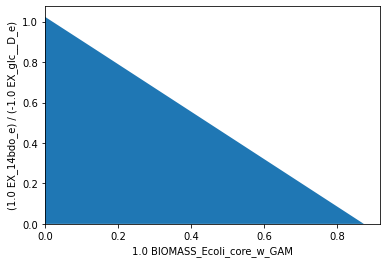

In [3]:
sd.plot_flux_space(ecc_14bdo, ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')));

Bacterial growth seems to compete with 1,4-BDO production. The maximum theoretical 1,4-BDO yield, is slightly above 1. We may now try to set realistic strain design goals. Assuming that knockout sets can be found the force a product yield above 0.3, while a growth rate of 0.15 is still attainable, we can specify according flux subspaces for protection or deletion through inequalities.

Since we decided to enforce a yield above 0.3, we aim to suppress all flux states with a yied inferior to this. Hence, we can describe the subspace of undesired fluxes with the inequality:
$$\frac{v_{1,4-BDO}}{v_{Glc,up}} \le 0.3$$
which can be linearized unter the assumption that $v_{Glc_up}>0$ to:
$$v_{1,4-BDO} - 0.3\, v_{Glc,up} \le 0$$

The flux states, which we aim to protect (at least partically) can be described by:
$$v_{growth} \ge 0.15$$

We can use the plotting function to visualize the flux subspaces that we would like to suppress (orange) or protect (green).

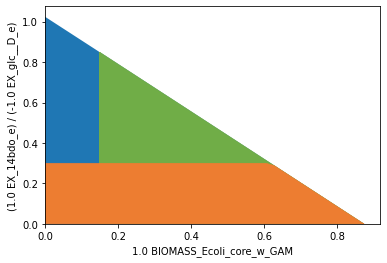

In [4]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.15',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

##### 3) Set up the strain design problem

The StrainDesign package uses so-called "strain design modules" to specify strain design goals. In the case of MCS, the goal is to suppress and protect flux spaces denoted by (sets of) linear inequalities. In the following we specify these modules.

In [4]:
module_suppress = sd.SDModule(ecc_14bdo,sd.names.SUPPRESS,constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0')
module_protect  = sd.SDModule(ecc_14bdo,sd.names.PROTECT, constraints='BIOMASS_Ecoli_core_w_GAM>=0.15')

It must be noted that suppressed or protected flux spaces are not only denoted by single inequalities, but are always subspaces of the original model. For instance, the set of flux vectors in the "suppressed" flux space is constrained by the specified inequality
$$v_{1,4-BDO}^{supp} - 0.3\, v_{Glc,up}^{supp} \le 0$$
**but also** by the model constraints
$$\mathbf{S\cdot v^{supp} = 0}$$
$$\mathbf{lb \le v^{supp} \le ub}$$

We must pay close attention when specifying *protect* and *suppress' modules, as, in either case, we avoid to include the trivial flux vector $\mathbf{v = 0}$ in the according subspace. If the trivial vector is contained in the *suppressed* flux space, the subspace cannot be suppressed, since the trivial vector can always be attained, even when all reactions were blocked. If the trivial vector is part of the *protected* flux space, the module will be uneffective, since reactions knockouts can never be disrupt this vector. 

In the case of the e_coli_core, it is unnecessary to exclude the 0-vector explicitly, since it is already excluded by default due to the minimum ATP maintenance demand. If this was not the case, one would need a auxiliary constraint, e.g., $ v_{Glc,up} \ge 0.1$.

##### 4) Compute strain designs

We can now proceed with the strain design computation. Since we normally don't know if solutions to our strain design problems exist, we will start the computation with the most relaxed settings possible. This means, we compute only one single solution, within a given MILP timelimit of 5 minutes (for genome-scale setups, this should be increased to an hour), while omitting the minimality demand in the solutions and allow up to 30 knockouts. For this initial approach, we also activate logging to follow the progress of the computation.

In [5]:
import logging
logging.basicConfig(level=logging.INFO)
# Compute strain designs
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 solution_approach = sd.names.ANY)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.reaction_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Compressing Network (103 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 59 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Last step could not reduce size further (59 reactions).
INFO:root:  Network compression completed. (1 compression iterations)
INFO:root:  Translating stoichiometric coefficients back to float.
INFO:root:  FVA(s) in compressed model to identify essential reactions.
INFO:root:Finished preprocessing:
INFO:root:  Model size: 59 reactions, 35 metabolites
INFO:root:  48 targetable reactions
INFO:root

One compressed solution with cost 7.0 found and expanded to 4 solutions in the uncompressed netork.
Example knockout set: ['PYK', 'SUCCt3', 'FUM', 'MDH', 'NADTRHD', 'AKGt2r', 'EX_glu__L_e']


##### 5) Analyze strain designs

We may plot the computed strain design (yellow) on top of the wild type model (blue), the suppressed fluxes (orange) and the protected fluxes (green). The designed strain is forced to produce 1,4-butanediol but is still able to grow at a rate higher than 0.15 1/h. 

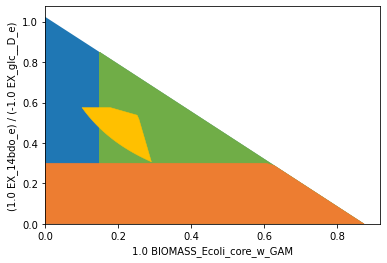

In [7]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.15',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
knockouts = [[{s:1.0},'=',0.0] for s in sols.reaction_sd[0]]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=knockouts,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

## Examle 1b: gene-KO-based strain designs with a minimum product (1,4-butanediol) yield (SUCP strain design)

##### 4) Compute strain designs

An easy way to compute gene-based MCS is to set the ``gene_kos`` parameter to True. All genes then are regarded as knockout candidates.

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
# Compute strain designs
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 solution_approach = sd.names.ANY,
                                 gene_kos = True)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.gene_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 113 genes and 56 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (306 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 162 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 140 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 133 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 132 r

One compressed solution with cost 0 found and expanded to 8 solutions in the uncompressed netork.
Example knockout set: ['pgi', 'kgtP', 'gltP', 'mdh', 'aceA', 'aceE', 'pykF', 'pykA', 'sucC']


##### 5) Analyze (gene-KO-based) strain designs

We may now analyze the resulting strain designs stored in ``sols.gene_sd``. When strain designs were computed with genetic interventions, such interventions need to be translated back to the reaction level in order to enable network analysis tools. This is done automatically at the end of each computation. The reaction-intervention equivalent can be accessed through the field ``sols.reaction_sd``.

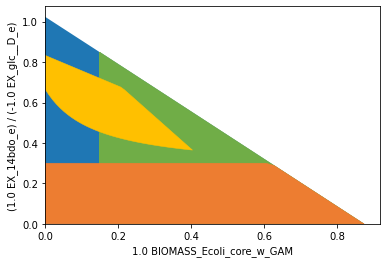

In [ ]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.15',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
knockouts = [[{s:1.0},'=',0.0] for s in sols.reaction_sd[0]]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=knockouts,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

As before, the designed strain complies with the specified MCS strain design goals.

## Examle 1c: gene-KO, regulatory and reactions-addition-based strain designs with a minimum product (1,4-butanediol) yield (SUCP strain design)

##### 4) Compute strain designs with different intervention types

There is an alternative pathway that can be used to produce the intermediate succinic semialdehyde branching from alpha-ketoglutarate. Only one reaction, AKGDC or SSCOARx, is needed for producing 1,4-BDO. We previously added the SSCOARx reaction. Now we also add AKGDC to the model.

In [6]:
# Add reaction to model
AKGDC = cobra.Reaction('AKGDC')
ecc_14bdo.add_reactions([AKGDC])
AKGDC.reaction = '1 akg_c + 1 h_c -> 1 co2_c + 1 sucsal_c'

For the MCS computation, we will now mark the reactions AKGDC and SSCOARx as "addition candidates". The algorithm will now combine a knockout strategy with the addition of one of the two reactions. For this computation example we will:
- relax the strain design demands.
- allow the knockout of all genes (apart from the pseudogene for spontanous reactions)
- allow the knockout of O2, therby simulating anaerobic conditions
- allow the limitation of O2 uptake down to a rate of below 1
- treat AKGDC and SSCOARx as addition candidates (Instead of reaction additions, one could also use gene-additions. Since the gene-reaction-association is 1:1, the computation results would be identical.). We associate different intervention costs to the addition of these reactions. AKGDC addition has the cost 1, SSCOARx addition has the cost 5.

In [7]:
module_suppress = sd.SDModule(ecc_14bdo,sd.names.SUPPRESS,constraints='EX_14bdo_e + 0.05 EX_glc__D_e <= 0')
module_protect  = sd.SDModule(ecc_14bdo,sd.names.PROTECT, constraints='BIOMASS_Ecoli_core_w_GAM>=0.02')

# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# possible throttling of O2 uptake
reg_cost = {'-EX_o2_e <= 1' : 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':5}

# compute strain designs
import logging
logging.basicConfig(level=logging.INFO)
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 max_cost = 9,
                                 solution_approach = sd.names.POPULATE,
                                 ko_cost = ko_cost,
                                 gko_cost = gko_cost,
                                 reg_cost = reg_cost,
                                 ki_cost = ki_cost)

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 105 genes and 48 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (285 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 136 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 114 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 105 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 104 r

In [8]:
from numpy import sign
for i,s in enumerate(sols.gene_sd):
    st = [['+'+t if v>0 else '-'+t][0] for t,v in s.items() if v != 0]
    print('solution '+str(i+1)+': '+', '.join(st))

solution 1: +SSCOARx, -pgi, -EX_o2_e
solution 2: +SSCOARx, -pgi, -cydB, -cbdA
solution 3: +SSCOARx, -pgi, -cydB, -cbdB
solution 4: +AKGDC, -pgi, -mdh, -kgtP, -gltP, -aceA, -pykF, -pykA, -sucC
solution 5: +AKGDC, -pgi, -mdh, -kgtP, -gltP, -aceA, -pykF, -pykA, -sucD
solution 6: +SSCOARx, -pgi, -pflA, -pflD, +-EX_o2_e <= 1
solution 7: +SSCOARx, -pgi, -pflA, -pflC, +-EX_o2_e <= 1
solution 8: +AKGDC, -pgi, -mdh, -sucB, -kgtP, -gltP, -aceA, -pykF, -pykA
solution 9: +SSCOARx, -pgi, -cydA, -cbdA
solution 10: +SSCOARx, -pgi, -cydA, -cbdB
solution 11: +SSCOARx, -pgi, -focA, -focB, +-EX_o2_e <= 1
solution 12: +SSCOARx, -pgi, -adhE, -mhpF, +-EX_o2_e <= 1
solution 13: +AKGDC, -pgi, -lpd, -mdh, -kgtP, -gltP, -aceA, -pykF, -pykA
solution 14: +AKGDC, -pgi, -mdh, -sucA, -kgtP, -gltP, -aceA, -pykF, -pykA


## Example 2: Enforce product (1,4-BDO) synthesis at all growth states (dGCP strain design)

For computing dGCP strain designs with MCS, we follow the identical steps from Example 1:

1) The production pathways, i.e., their metabolites and reactions are added to the model.
2) Analysis tools are used to identify adequate strain design goals. 
3) Set up the according strain design problem by specifying two strain design *modules*, one that demand the suppression of flux states with low product yields, the other one protecting the functions that are essential for bacterial growth.
4) The strain design function is called, passing the model and the strain design module as function arguments.
5) The results are analyzed.

##### 1) Add and verify production pathway (skipped, since the steps are identical to Example 1)

##### 2) Analyze model with production envelope 

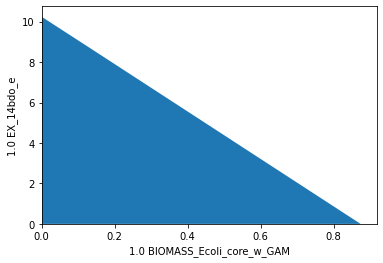

In [4]:
# Plot production envelope
sd.plot_flux_space(ecc_14bdo, ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'));

##### 3) Set up the dGCP strain design modules

For dGCP, we demand that all flux states of microbial growth carry production. Ideally, we want to (a) ensure a minimum ratio of product synthesis rate and growth rate $\frac{v_{product}}{v_{growth}} > Y_{P/BM}^{min}$ (2) ensure that growth is still possible. Hence, we define one suppression and one protection module.

Suppress module (removin flux states, where $\frac{v_{product}}{v_{growth}} > Y_{P/BM}^{min}$):
$$v_{product} - Y_{P/BM}^{min} v_{growth} \le 0$$
$$v_{growth} \ge 0.01~h^{-1}$$
The latter constraint is used to explicitly exclude the $\mathbf{v=0}$ vector from the suppressed flux states. Here, we use an arbitrary threshold of $Y_{P/BM}^{min} = 5$ that we inferred from the production envelope.

Protect module:
$$v_{growth} \ge 0.15~h^{-1}$$

In [3]:
module_suppress = sd.SDModule(ecc_14bdo,sd.names.SUPPRESS,constraints=['EX_14bdo_e - 5 BIOMASS_Ecoli_core_w_GAM <= 0', 
                                                                       'BIOMASS_Ecoli_core_w_GAM >= 0.01'])
module_protect  = sd.SDModule(ecc_14bdo,sd.names.PROTECT, constraints='BIOMASS_Ecoli_core_w_GAM>=0.15')

Plotting the flux spaces in the production envelope returns:

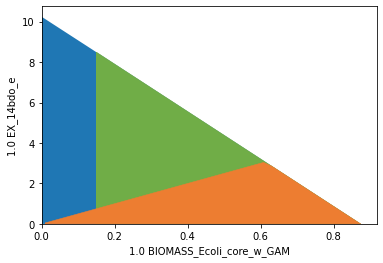

In [4]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.15',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=['EX_14bdo_e - 5 BIOMASS_Ecoli_core_w_GAM <= 0', 
                                                            'BIOMASS_Ecoli_core_w_GAM >= 0.01'],
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

In [6]:
import logging
logging.basicConfig(level=logging.INFO)
# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}

# compute strain designs
import logging
logging.basicConfig(level=logging.INFO)
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 max_solutions = 1,
                                 max_cost = 30,
                                 solution_approach = sd.names.BEST,
                                 ko_cost = ko_cost,
                                 gko_cost = gko_cost)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example gene knockout set: {[s for s in sols.gene_sd[0]]}")
print(f"Knockout set on the reaction level: {[s for s in sols.reaction_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.


ValueError: 'PIt2r*BIOMASS_Ecoli_core_w_GAM*EX_pi_e' is not in list

##### 5) Analyze the results

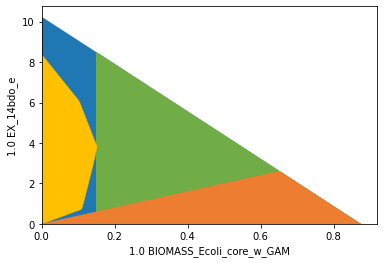

In [14]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.15',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=['EX_14bdo_e - 4 BIOMASS_Ecoli_core_w_GAM <= 0', 
                                                            'BIOMASS_Ecoli_core_w_GAM >= 0.01'],
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
knockouts = [[{s:1.0},'=',0.0] for s in sols.reaction_sd[0]]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=knockouts,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

## Example 3: Suppress flux states that are optimal with respect to a pre-defined objective function (wGCP strain design)

The MCS approach also allows the suppression or protection of flux vectors that are optimal regarding a pre-defined objective function. The following two setups show, how the 

## Example 4: Protect flux states that are optimal with respect to a pre-defined objective function (pGCP strain design)

The MCS approach also allows the suppression or protection of flux vectors that are optimal regarding a pre-defined objective function. The following two setups show, how the 

## Example 5: All single gene knockouts that prohibit growth (synthetic lethals).

The MCS approach can be used to identify essential genes. For this type of computation we may use the MCS approach with a single suppress-module that targets flux states of microbial growth, i.e. flux states in which the inequality
$$ v_{Biomass} > 0$$
approximated as
$$ v_{Biomass} \ge 0.001$$
holds. We construct the corresponding module and launch an exhaustive computation of all solutions of the size 1.

In [ ]:
# Construct module
module_suppress  = sd.SDModule(ecc,sd.names.SUPPRESS, constraints='BIOMASS_Ecoli_core_w_GAM>=0.001')
# Compute strain designs
sols = sd.compute_strain_designs(ecc,
                                 sd_modules = module_suppress,
                                 max_cost = 1,
                                 solution_approach = sd.names.POPULATE,
                                 gene_kos = True)
# Print solutions
print(f"{len(sols.gene_sd)} solutions were found.")
for i,sol in enumerate(sols.gene_sd):
    print(f"Solution {i+1}: {[s for s in sol][0]}")

7 solutions were found.
Solution 1: dict_keys(['gltA'])
Solution 2: dict_keys(['eno'])
Solution 3: dict_keys(['ptsH'])
Solution 4: dict_keys(['ptsI'])
Solution 5: dict_keys(['gapA'])
Solution 6: dict_keys(['pgk'])
Solution 7: dict_keys(['icd'])


## Example 6: Suppress flux states in a toy network

The MCS concept can be showcased in a small example network:

<img style="float:left; width:20%" src="../img/SmallExample.svg" />

Suppose, we want block all metabolic flux through **R4** to avoid the production of metabolite **E**. One can now identify irreducible sets of reaction knockouts to achieve this. Each of these set is called a minimal cut set, short MCS. This figure shows all possible MCS for blocking reaction R4.

<img style="float:left; width:70%" src="../img/SmallExample_mcs1.svg" />


Set up the according strain design problem by specifying a *module* that demands the suppression of flux states with $R4 > 0$. 

Since strict inequalities are not allowed in mixed integer linear programming (MILP), we need to approximate it by an inclusive inequality and a sufficiently small value $\varepsilon>0$. Here we pick $\varepsilon=1$, such that the flux states that we aim to delete are those that fulfill the inequality:

$$R4 >= 1$$

In [ ]:
modules  =  [sd.SDModule(model,sd.names.SUPPRESS,constraints='R4 >= 1')]
# modules +=  [sd.SDModule(model,sd.names.PROTECT, constraints='R3 >= 1')]


sols = sd.compute_strain_designs(model,sd_modules = modules)
for s in sols.reaction_sd:
    print(s)

{'R1': -1.0}
{'R3': -1.0}
{'R4': -1.0}
{'R7': -1.0}
{'R10': -1.0}
{'R6': -1.0, 'R8': -1.0}
{'R2': -1.0, 'R5': -1.0, 'R6': -1.0}


An adequate value for $\varepsilon$ can inferred from the model, i.e., the coefficients of the stoichiometric matrix and the flux boundaries. In the shown example values of 1e-7 up to 50 will yield the same results. However, too small values may result in longer runtimes or numerical issues. While large values may not approximate the strict inequality well enough.

## Example 7: Suppress and protect flux states in a toy network

It may sometimes be required to protect certain flux states, for instance, to guarantee that the model stays feasible despite the deletion, or to guarnatee that microbial growth is still possible despite the introduced where **R4** must be deleted and additionally demand that **R3** must still be able to carry flux.

In [ ]:
import straindesign as sd
import cobra

model = cobra.io.read_sbml_model('../../../tests/model_small_example.xml')

modules =   [sd.SDModule(model,sd.names.SUPPRESS,constraints='R4 >= 1')]
modules +=  [sd.SDModule(model,sd.names.PROTECT, constraints='R3 >= 1')]

sols = sd.compute_strain_designs(model,sd_modules = modules)
for s in sols.reaction_sd:
    print(s)

{'R1': -1.0}
{'R4': -1.0}
{'R7': -1.0}
{'R10': -1.0}
{'R6': -1.0, 'R8': -1.0}


As can be seen, the computation returns the 5 out of 7 MCS that block R4 but not R3. The set of theses *constrained* MCS (cMCS) is a subset of the former MCS solution pool.

<img style="float:left; width:70%" src="../img/SmallExample_mcs2.svg" />

## Theoretical background

Farkas' Lemma.
Continued ...